配置环境

In [15]:
# 导入必要的库
import torch
import torch.nn as nn
import random
from torch.utils.data.dataloader import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from tools_np_nd import *

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(27)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

定义超参数

In [16]:
# 定义超参数
batch_size = 5 # 批次大小
learning_rate = 0.001 # 学习率
num_epochs = 100 # 训练轮数
train_length = 0.8 # 训练数据长度
step_size     = 20 # 学习率变化周期
gamma         = 0.1 # 学习率更新值
learning_rate = 0.002 # 学习率

数据预处理

In [17]:
# 创建训练数据集和测试数据集

train_data = create_train_dataset()
test_data = create_test_dataset()

# 分离出训练集和测试集

train =  train_data
np.random.shuffle(train)


# 数据归一化
scaler, train_scaled = train_scale(train)
dataset = DataPrepare(train_scaled) # 设置 inputs 和 labels
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=True)

BiLSTM 模型

In [18]:
# 定义 BiLSTM 模型
class BiLSTM(nn.Module):
    def __init__(self, input_size = 5, hidden_size = 100, num_layers = 2, output_size = 1):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size) # 乘以2是因为双向的输出要拼接

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 乘以2是因为双向的隐藏层要分开
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # 通过 BiLSTM 层
        out, _ = self.bilstm(x, (h0, c0))
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        # 通过全连接层
        out = self.fc(out)
        return out

# 创建模型实例
model = BiLSTM().to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam 优化器
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

训练模型

In [19]:
# 训练模型
min_epochs = 10
best_model = None
min_loss = 0.2

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 1, 5)

        # 梯度清零
        optimizer.zero_grad()
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        
        # 前向传播
        y_pred = model(inputs)
        
        # 计算损失
        loss = loss_function(labels, y_pred)
        train_loss.append(loss.cpu().item())
        
        # 更新梯度
        loss.backward()
        
        # 优化参数
        optimizer.step()


    scheduler.step()  # 调整学习率

    if epoch > min_epochs and np.mean(train_loss) < min_loss:
        min_loss = np.mean(train_loss)
        best_model = copy.deepcopy(model)
        
    
    if epoch % 10 == 0:
        print('epoch {} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))

torch.save(model, r'./result_np_nd/BiLSTM_model_np_nd.pth')

epoch 0 train_loss 0.00415415
epoch 10 train_loss 0.00065380
epoch 20 train_loss 0.00040624
epoch 30 train_loss 0.00037097
epoch 40 train_loss 0.00035120
epoch 50 train_loss 0.00034941
epoch 60 train_loss 0.00034730
epoch 70 train_loss 0.00034704
epoch 80 train_loss 0.00034676
epoch 90 train_loss 0.00034673


测试模型

In [20]:
# 测试模型
scaler, test_scaled = test_scale(test_data)

with torch.no_grad():
    model = torch.load("./result_np_nd/BiLSTM_model_np_nd.pth")
    print(model)
    
    # 预测测试数据
    print('Forecasting Testing Data')
    predictions_test = list() # 预测值
    expected = list() # 真实值
    test_dataset = DataPrepare(test_scaled) # 分离 inputs 和 labels
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # 加载数据
    for i, data in enumerate(test_loader, 0):
        # make one-step forecast
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.reshape(batch_size, 1, 5)
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        # yhat 为预测值
        yhat = model(inputs)
        
        for j in range(yhat.shape[0]):
            yhat[j] = invert_scale(scaler, inputs[j].reshape(5, -1).cpu().numpy(), 
            yhat[j].cpu().detach().numpy())
            labels[j] = invert_scale(scaler, inputs[j].reshape(5, -1).cpu().numpy(),
            labels[j].cpu().detach().numpy())
            predictions_test.append(yhat[j].cpu().detach().numpy()) # 预测值序列
            expected.append(labels[j].cpu().detach().numpy()) # 真实值序列
        

    # RMSE 评价指标
    rmse_test = sqrt(mean_squared_error(np.array(expected) / 2, np.array(predictions_test) / 2))
    print('Test RMSE: %.8f' % rmse_test)

BiLSTM(
  (bilstm): LSTM(5, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)
Forecasting Testing Data
Test RMSE: 0.01778997


后处理

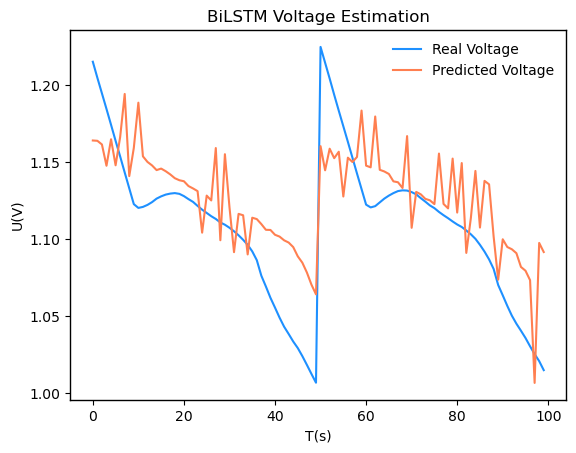

In [21]:
# 绘制 Voltage 预测图像
# 创建横坐标
data_num = len(expected)
Cyc_X = np.linspace(0, data_num, data_num)
fig = plt.figure()
sub = fig.add_subplot(111) # 1*1 的网格中第一个图像
sub.plot(expected, c='dodgerblue', label='Real Voltage', linewidth=1.5)
sub.plot(predictions_test, c='coral', label='Predicted Voltage', linewidth=1.5)

# 设置坐标轴
ax = plt.gca()
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
plt.tick_params(labelsize=10) # 刻度标签字体大小
plt.legend(loc=1, edgecolor='w') # 创建图例
plt.ylabel('U(V)')
plt.xlabel('T(s)')
plt.title('BiLSTM Voltage Estimation')
plt.savefig(r'./result_np_nd/Voltage_result.png')
plt.show()